<a href="https://www.kaggle.com/code/ernestbeardlypani/icr-identifying-age-related-conditions-eda?scriptVersionId=137106946" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Initializations

In [1]:
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import numpy as np
import pickle

In [2]:
import sys

# Import utility scripts folder
script_path = '/kaggle/usr/lib/tools/'
sys.path.append(script_path)

from borutashap import *
from automatedfeatureengineering import AutomatedFeatureEngineering

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
import sklearn.preprocessing as pp #import StandardScaler, FunctionTransformer, MinMaxScaler
#from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import sklearn.decomposition as dc
from sklearn.metrics import make_scorer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.compose import make_column_transformer

In [4]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

In [5]:
from tpot import TPOTClassifier
import sklearn.ensemble as es
import sklearn.model_selection as ms

In [6]:
open('tools.py', 'w').write('''
import sklearn.preprocessing as pp
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
import numpy as np

class ModelWrapper(BaseEstimator):
    __sklearn_is_fitted__ = lambda: True
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y=None, **kwargs):
        self.model.fit(X, y, **kwargs)
        return self
    
    def predict(self, X):
        probabilities = self.predict_proba(X)
        p0 = probabilities[:,:1]
        p0[p0 > 0.86] = 1
        p0[p0 < 0.14] = 0
        y_p = np.empty((len(p0),))
        for i in range(len(p0)):
            if p0[i]>=0.5:
                y_p[i]= False
            else :
                y_p[i]=True
        return y_p.astype(int)
        
    def predict_proba(self, X):
        averaged_probabilities = self.model.predict_proba(X)
        class_0_est_instances = averaged_probabilities[:, 0].sum()
        others_est_instances = averaged_probabilities[:, 1:].sum()
        # Weighted probabilities based on class imbalance
        new_probabilities = averaged_probabilities * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(averaged_probabilities.shape[1])]])
        y_pred = new_probabilities / np.sum(new_probabilities, axis=1, keepdims=1) 
        probabilities = np.concatenate((y_pred[:,:1], np.sum(y_pred[:,1:], 1, keepdims=True)), axis=1)
        return probabilities
        
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.fitted = False

    def fit(self, X, y=None):
        if self.fitted:
            return self
        
        Q1 = np.quantile(X, q=0.25, axis=0)
        Q3 = np.quantile(X, q=0.75, axis=0)
        IQR = Q3 - Q1
        
        self.lower = Q1-10*IQR
        self.upper = Q1+10*IQR
        
        self.fitted = True
        return self

    def transform(self, X):
        X = self.lower*(X<self.lower)+X*(X>=self.lower)
        X = self.upper*(X>self.upper)+X*(X<=self.upper)
        return X

class Preprocessor(TransformerMixin):
    def __init__(self):
        self.preprocessor = make_column_transformer(
            (make_pipeline(
                IterativeImputer(random_state=0),
                OutlierHandler(),
                pp.PowerTransformer(standardize=False)
            ), slice(0, -1)),
            (KNNImputer(), [-1])
        )

    def fit(self, X, y=None):
        self.preprocessor.fit(X, y)
        return self

    def transform(self, X):
        return self.preprocessor.transform(X)

    def fit_transform(self, X, y=None):
        return self.preprocessor.fit_transform(X, y)
''')

from tools import *

# Load data

In [7]:
train_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')

In [8]:
features = [n for n in train_df.columns if n not in ['Id', 'Class', 'Alpha']]
extra_features = ['Epsilon']

In [9]:
from datetime import datetime
times = greeks[["Id", "Alpha", "Epsilon"]].copy()
times.loc[greeks.Epsilon != 'Unknown', "Epsilon"] = greeks.Epsilon[greeks.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal())
times.loc[greeks.Epsilon == 'Unknown', "Epsilon"] = np.nan
times["Epsilon"] = times["Epsilon"].astype("float32")
times["Alpha"] = pp.LabelEncoder().fit_transform(times["Alpha"]).astype("int")

train_df = pd.merge(train_df, times, on='Id')

# EDA

In [10]:
print(f"Num. features: {len(features)}")
print(f"Num. train rows: {len(train_df)}")

Num. features: 56
Num. train rows: 617


## Data types

In [11]:
train_df.dtypes

Id          object
AB         float64
AF         float64
AH         float64
AM         float64
AR         float64
AX         float64
AY         float64
AZ         float64
BC         float64
BD         float64
BN         float64
BP         float64
BQ         float64
BR         float64
BZ         float64
CB         float64
CC         float64
CD         float64
CF         float64
CH         float64
CL         float64
CR         float64
CS         float64
CU         float64
CW         float64
DA         float64
DE         float64
DF         float64
DH         float64
DI         float64
DL         float64
DN         float64
DU         float64
DV         float64
DY         float64
EB         float64
EE         float64
EG         float64
EH         float64
EJ          object
EL         float64
EP         float64
EU         float64
FC         float64
FD         float64
FE         float64
FI         float64
FL         float64
FR         float64
FS         float64
GB         float64
GE         f

Column EJ is of type "object". Lets check it out!

In [12]:
train_df["EJ"].unique()

array(['B', 'A'], dtype=object)

The column contains A and B values only. We can convert it to 0 and 1 with onehot encoding.

## Spaces in feature names
Spaces in feature names may cause errors.

In [13]:
colname_with_space = [col for col in train_df.columns if col.find(" ")!=-1]
colname_with_space

['BD ', 'CD ', 'CW ', 'FD ']

Its a good practice to remove the trailing space in column name to prevent errors.

## Is data normalized?

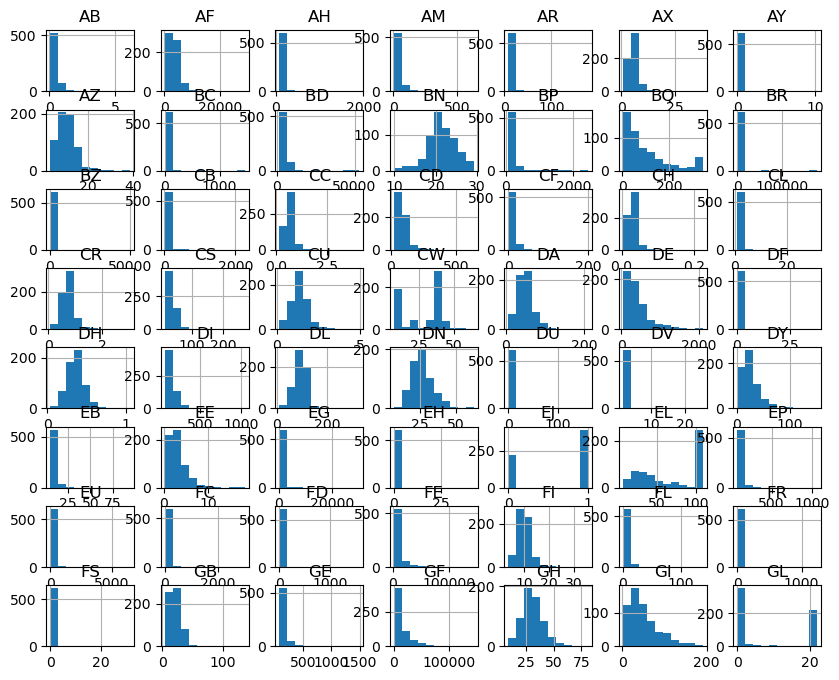

In [14]:
train_df[features].replace({'A': 0, 'B': 1}).hist(figsize=(10, 8))
plt.show()

The data is not normalized yet. Its a good practice to normalize the data first to boost performance.

## Imbalance data

In [15]:
print(train_df["Alpha"].value_counts())

0    509
1     61
3     29
2     18
Name: Alpha, dtype: int64


The amount of class is not balanced, and there is not much data.

## Null values

In [16]:
len(train_df[train_df.isna().any(axis=1)])

187

There are 69 rows with NaN.

<Axes: >

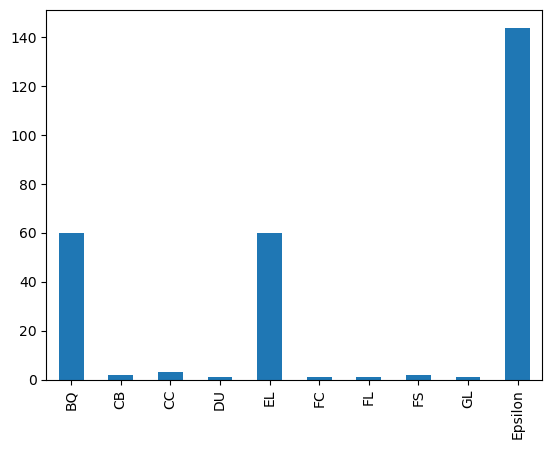

In [17]:
columns_with_na = train_df.apply(lambda x: len(x[x.isna()]), axis=0)
columns_with_na[columns_with_na>0].plot(kind="bar")

## Correlations

<Axes: >

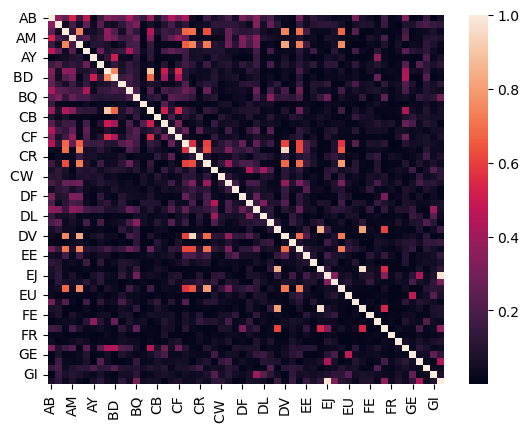

In [18]:
sns.heatmap(train_df[features].replace({'A': 0, 'B': 1}).corr().abs())

There are some highly correlated features. Feature selection is necessary.

## Outliers

In [19]:
scaled_df = train_df[features].replace({'A': 0, 'B': 1})
scaled_df = (scaled_df - scaled_df.mean(axis=0)) /  scaled_df.std(axis=0) 

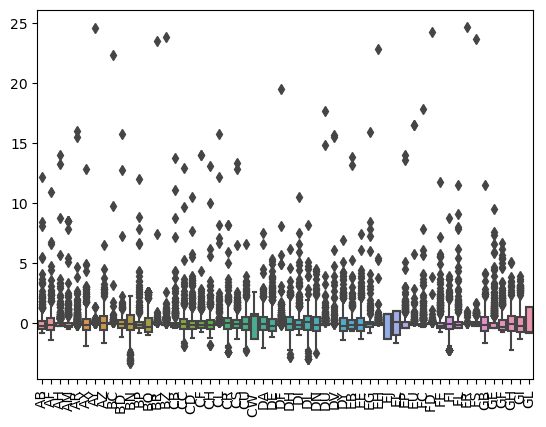

In [20]:
sns.boxplot(data=scaled_df)
plt.xticks(rotation=90)
plt.show()

Almost all features has outliers. Lets count the number of outliers in each columns. I will use the IQR method.

<Axes: >

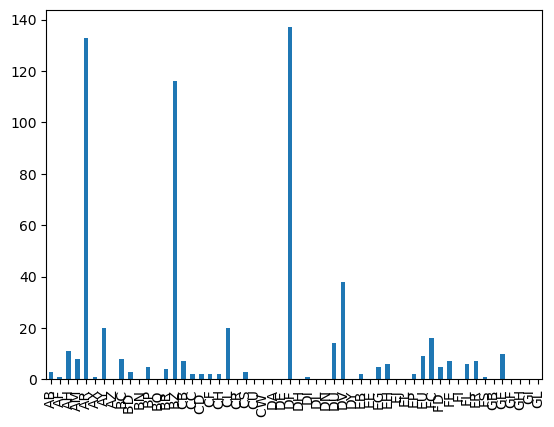

In [21]:
Q1 = scaled_df.quantile(0.25, axis=0)
Q3 = scaled_df.quantile(0.75, axis=0)
IQR = Q3 - Q1

outliers_count = scaled_df.apply(lambda x: len(x[((x<(Q1[x.name]-10*IQR[x.name])) | (x>(Q3[x.name]+10*IQR[x.name])))]), axis=0)
outliers_count.plot(kind="bar")

- Should we drop the columns with many (more than 10%) outliers?
- Should we drop the rows with outliers?
- Should we clip the values?

## Data processing todo list:
1. Remove trailing space in column names
2. Convert EJ column values from A and B to 0 and 1 respectively.
3. Handle NaN.
4. Handle outliers
5. Normalize dataset
6. Handle imbalance dataset
7. Feature selection

# Data processing

## 1. Remove trailing space in column names

In [22]:
train_df = train_df.rename(columns=lambda x: x.strip())
features = [n for n in train_df.columns if n not in ['Id', 'Class', 'Alpha', 'Epsilon']]

## 2. Convert EJ column values from A and B to 0 and 1 respectively

In [23]:
train_df["EJ"] = train_df["EJ"].replace({'A': 0, 'B': 1})
train_df["EJ"].head()

0    1
1    0
2    1
3    1
4    1
Name: EJ, dtype: int64

## 3. Handle NaN

### Create new_df for experimental dataset

In [24]:
new_df = train_df.copy()

### Impute data

In [25]:
imputer = IterativeImputer(random_state=0)
new_df[features] = imputer.fit_transform(new_df[features])

In [26]:
len(new_df[new_df.isna().any(axis=1)])

144

## 4. Handle outliers

### Count extreme outliers in each columns.

<Axes: >

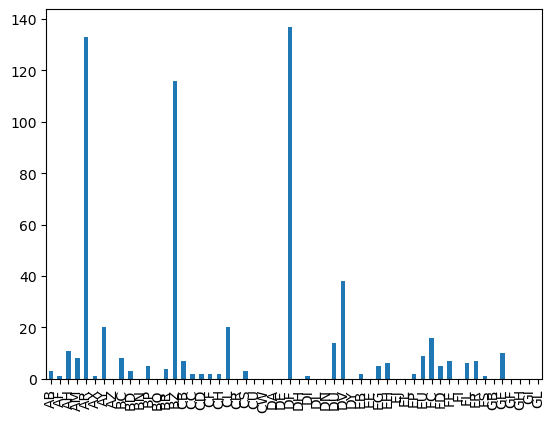

In [27]:
Q1 = new_df[features].quantile(0.25, axis=0)
Q3 = new_df[features].quantile(0.75, axis=0)
IQR = Q3 - Q1
outliers_count = new_df[features].apply(lambda x: len(x[((x<(Q1[x.name]-10*IQR[x.name])) | (x>(Q3[x.name]+10*IQR[x.name])))]), axis=0)
outliers_count.plot(kind="bar")

## Handling extreme outliers

### Delete features with more than 10% outliers

In [28]:
to_remove = outliers_count[outliers_count/len(train_df)>.1]
to_remove

AR    133
BZ    116
DF    137
dtype: int64

In [29]:
good_features = list(set(features) - set(to_remove.index))

### Handling the rest

In [30]:
outlier_handler = OutlierHandler()
new_df[good_features] = outlier_handler.fit_transform(new_df[good_features])

## Count extreme outliers after handled

<Axes: >

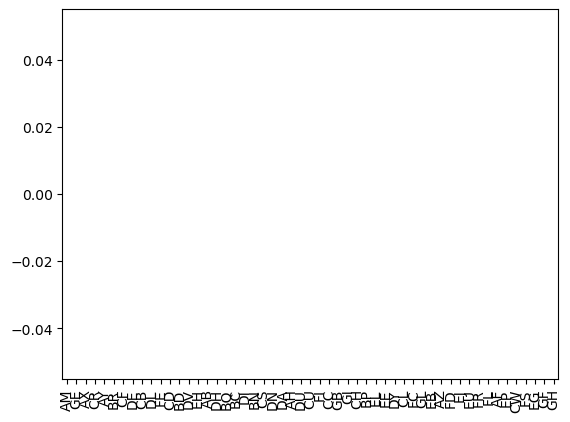

In [31]:
Q1 = new_df[good_features].quantile(0.25, axis=0)
Q3 = new_df[good_features].quantile(0.75, axis=0)
IQR = Q3 - Q1
outliers_count = new_df[good_features].apply(lambda x: len(x[((x<(Q1[x.name]-10*IQR[x.name])) | (x>(Q3[x.name]+10*IQR[x.name])))]), axis=0)
outliers_count.plot(kind="bar")

## 5. Normalize dataset

For the normalization method, I will use the power_transform method.

In [32]:
to_normalize = list(set(good_features) - set(["EJ"]))

In [33]:
normalizer = pp.PowerTransformer(standardize=False)
new_df[to_normalize] = normalizer.fit_transform(new_df[to_normalize])

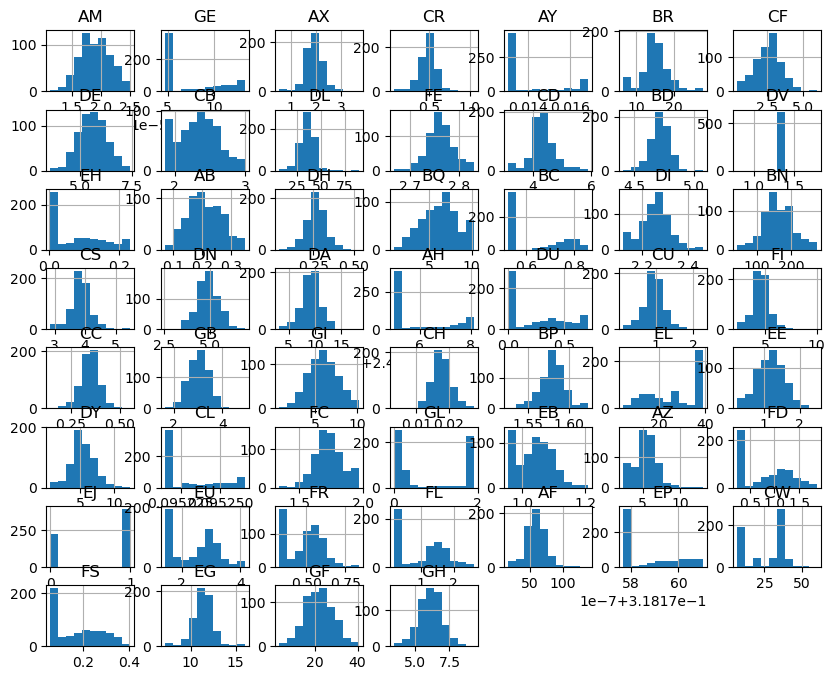

In [34]:
new_df[good_features].hist(figsize=(10, 8))
plt.show()

## 6. Handle imbalance dataset

I will use oversampling method to handle imbalance data.

In [35]:
ros = RandomOverSampler(random_state=200)

new_df, y_alpha = ros.fit_resample(new_df, new_df["Alpha"])

In [36]:
print(new_df["Alpha"].value_counts())

1    509
0    509
2    509
3    509
Name: Alpha, dtype: int64


## 7. Feature selection

In [37]:
Feature_Selector = BorutaShap2(model=XGBClassifier(seed=200), 
                              importance_measure='shap', 
                              classification=True,
                              percentile=100,
                              pvalue=0.0001)

Feature_Selector.fit(X=new_df[good_features], 
                     y=new_df['Alpha'],
                     sample=False, 
                     train_or_test='test', 
                     normalize=False, 
                     verbose=True)

  0%|          | 0/20 [00:00<?, ?it/s]

44 attributes confirmed important: ['AM', 'AX', 'CR', 'BR', 'DL', 'DE', 'CB', 'FE', 'CD', 'BD', 'EH', 'AB', 'DH', 'BQ', 'BC', 'BN', 'CS', 'DA', 'DU', 'CU', 'FI', 'CC', 'GB', 'BP', 'EL', 'EE', 'DY', 'CL', 'FC', 'GL', 'EB', 'AZ', 'FR', 'FD', 'CW', 'EU', 'FL', 'AF', 'EP', 'DN', 'FS', 'EG', 'GF', 'GH']
3 attributes confirmed unimportant: ['DV', 'EJ', 'AH']
6 tentative attributes remains: ['GE', 'AY', 'GI', 'CH', 'DI', 'CF']


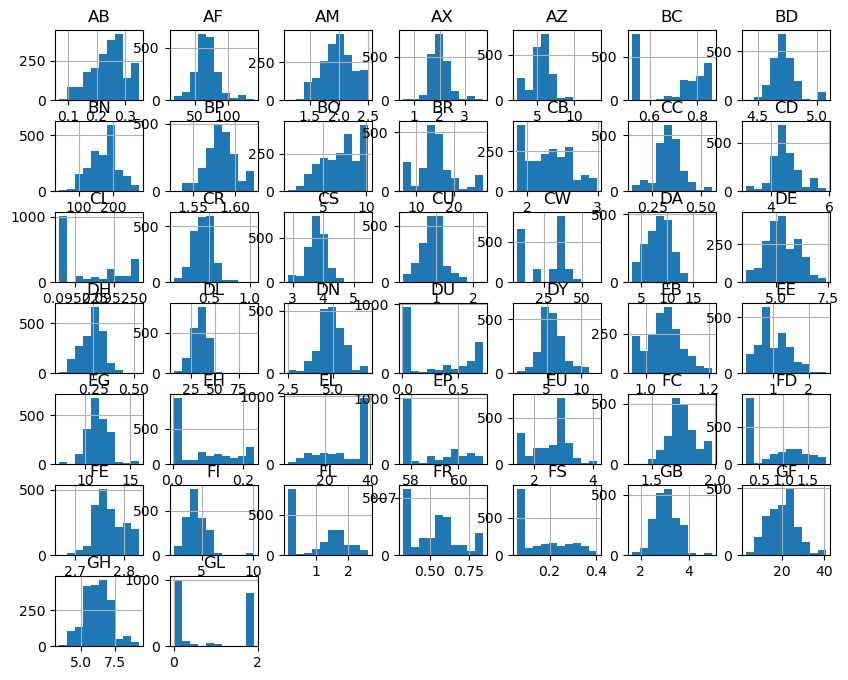

In [38]:
good_features = Feature_Selector.accepted
good_features.sort()

new_df[good_features].hist(figsize=(10, 8))
plt.show()

<Axes: >

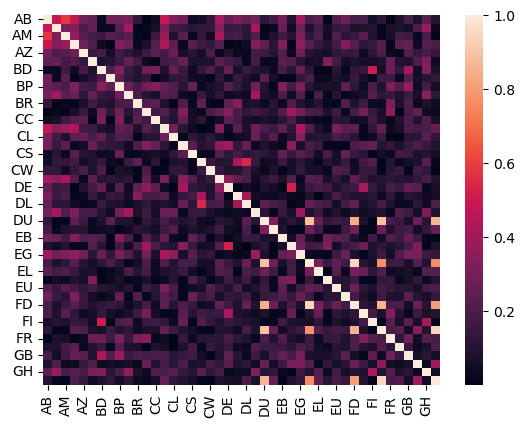

In [39]:
sns.heatmap(new_df[good_features].corr().abs())

## Save good features

In [40]:
good_features = good_features + extra_features

with open(f'good_features.pkl', 'wb') as f:
    pickle.dump(good_features, f)

# Model Selection

## Prepare training data

In [41]:
ros = RandomOverSampler(random_state=200)
train_df, y_alpha = ros.fit_resample(train_df, train_df["Alpha"])

In [42]:
train_df.to_csv('train.csv', index=False)

## Model maker

In [43]:
def make_model(estimator):
    return Pipeline([
        ("preprocessor", Preprocessor()),
        ("model", ModelWrapper(estimator))
    ])

## Competition loss function

In [44]:
# A weighted average log-loss - same as the competion LL but with
# an overall constant that varies with the class ratio.
# slightly modified from
# https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/409691
def balanced_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    # (factgor of 2 included to give same result as LL with balanced input)
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    # return the average log loss
    return balanced_log_loss/(N_0+N_1)

def balanced_log_loss_scorer(estimator, X, y_t):
    estimator = ModelWrapper(estimator)
    y_p = estimator.predict(X)
    y_t[y_t>0] = 1
    score = -balanced_log_loss(y_t, y_p)
    return score

## Pipeline Evaluator

In [45]:
def model_evaluator(X, y):
    models = [
        ("XGBClassifier", XGBClassifier(seed=200)),
        ("LGBMClassifier", LGBMClassifier(random_state=200, verbose=-1)),
        ("CatBoostClassifier", CatBoostClassifier(random_seed=200, verbose=0)),
        ("SVC", SVC(probability=True, random_state=200)),
        ("RandomForestClassifier", RandomForestClassifier(random_state=200)),
    ]

    model_scores = {}
    for name, estimator in models:
        model = make_model(estimator)
        scores = cross_val_score(model, X, y, 
                                 cv=ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=200), 
                                 groups=y, 
                                 scoring=balanced_log_loss_scorer)
        model_scores[name] = -np.mean(scores)
    
    return model_scores

# Model Selection

In [46]:
X_train, y_train = train_df[good_features], train_df["Alpha"]
model_scores = model_evaluator(X_train, y_train)

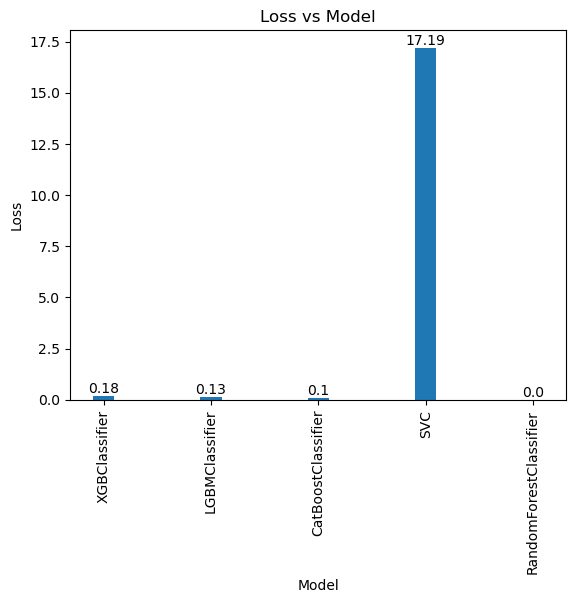

In [47]:
score_x = model_scores.keys()
score_y = model_scores.values()

x = np.arange(len(score_x))
width = 0.2
plt.bar(x, score_y, width=width)#, label='Original')

for i, v in enumerate(score_y):
    plt.text(i, v, str(round(v,2)), ha='center', va='bottom')

# Add labels, title, and legend
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Loss vs Model')
plt.xticks(x, score_x, rotation=90)
#plt.figure(figsize=(8, 6), num=1)
#plt.legend()
plt.show()

- Model performance increase greatly with processed data and feature selection
- Gradient boosting models and RandomForestClassifier does well for the dataset.

### Next steps:
- Do hyperparameter tuning on XGBClassifier, LGBMClassifier, CatBoostClassifier, and RandomForestClassifier models.
- Ensemble models

# Hyperparameter Tuning

For hyperparameter tuning, I will use the genetic algorithmn hyperparameter tuner, TPOT.

In [48]:
class TPOTClassifier2(TPOTClassifier):
    def _check_dataset(self, features, target, sample_weight=None):
        return features, target
    
    def _fit_init(self):
        super()._fit_init()
        self._fitted_imputer = pp.FunctionTransformer()

In [49]:
def get_best_params(generations=10, population_size=20, random_state = 0):
    preprocessor = Preprocessor()
    transformer = {
        'tools.Preprocessor': {}
    }
    
    tpot_configs = {
        'sklearn.ensemble.RandomForestClassifier': {
            'n_estimators': [100, 200, 400, 800, 1600],
            'max_depth': [3,4,5,6,7,8,9,10, None],
            'criterion': ["gini", "entropy", "log_loss"],
            'max_features': np.arange(0.05, 1.01, 0.05),
            'min_samples_split': range(2, 21),
            'min_samples_leaf':  range(1, 21),
            'n_jobs': [-1],
            'bootstrap': [True, False],
            'random_state': [random_state]
        },
        'xgboost.XGBClassifier': {
            'n_estimators': [100, 200, 400, 800, 1600],
            'colsample_bytree': np.arange(0.1,1.0,0.1), 
            'learning_rate':np.arange(0.002,0.4,0.002), 
            'max_depth':[3,4,5,6,7,8,9,10],
            'objective':["multi:softmax", "multi:softprob"], 
            'reg_alpha':[0,1,2,3,4,5,6], 
            'reg_lambda':[0,1,2,3,4,5,6], 
            #'tree_method':['gpu_hist'],
            'random_state':[random_state]
        },
        'lightgbm.LGBMClassifier': {
            'n_estimators': [100, 200, 400, 800, 1600],
            'learning_rate': np.arange(0.002, 0.4, 0.02),
            'max_depth': [-1, 3, 4, 5, 6, 7, 8, 9, 10],
            'num_leaves': [31, 50, 100, 200, 300],
            'boosting_type': ['gbdt', 'dart', 'goss'],
            'subsample': np.arange(0.1, 1.0, 0.1),
            'colsample_bytree': np.arange(0.1, 1.0, 0.1),
            'reg_alpha': [0, 1, 2, 3, 4, 5, 6],
            'reg_lambda': [0, 1, 2, 3, 4, 5, 6],
            'n_jobs': [-1],
            'random_state': [random_state],
        },
        'catboost.CatBoostClassifier': {
            'n_estimators': [100, 200, 400, 800, 1600],
            'colsample_bylevel': np.arange(0.1,1.0,0.1), 
            'learning_rate':np.arange(0.002,0.4,0.02), 
            'max_depth':[3,4,5,6,7,8,9,10],
            'objective':["MultiClass", "MultiClassOneVsAll"], 
            'model_size_reg':[0,1,2,3,4,5,6], 
            'reg_lambda':[0,1,2,3,4,5,6], 
            'verbose':[0],
            #'task_type': ["GPU"],
            'random_seed':[random_state]
        },
    }

    best_params = {}
    for name, config in tpot_configs.items():
        # Create TPOT regressor object
        tpot = TPOTClassifier2(
            generations=generations,
            population_size=population_size,
            crossover_rate=0.2,
            mutation_rate=0.8,
            verbosity=2,
            random_state=random_state,
            scoring=balanced_log_loss_scorer,
            n_jobs=-1,
            cv=ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=200),
            template="Transformer-Classifier",
            config_dict={name: config, **transformer}
        )

        # Fit TPOT on the training data
        tpot.fit(train_df[good_features], 
                 train_df["Alpha"],
                 groups=train_df["Alpha"])

        model = tpot.fitted_pipeline_
        estimator = model.steps[1][1]
        model_params = estimator.get_params()
        model_params = {key: value for key, value in model_params.items() if key in config.keys()}
        if name=='xgboost.XGBClassifier':
            model_params["n_estimators"] = estimator.n_estimators
        best_params[name] = model_params
        print(f"Best {name} params:", model_params)
        
    return best_params

In [50]:
best_params = get_best_params(generations=10, population_size=10, random_state = 200)
best_xgb = best_params["xgboost.XGBClassifier"]
best_lgb = best_params["lightgbm.LGBMClassifier"]
best_cat = best_params["catboost.CatBoostClassifier"]
best_rfc = best_params["sklearn.ensemble.RandomForestClassifier"]

Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -7.493969224004143e-16

Generation 2 - Current best internal CV score: -7.493969224004143e-16

Generation 3 - Current best internal CV score: -7.493969224004143e-16

Generation 4 - Current best internal CV score: -7.493969224004143e-16

Generation 5 - Current best internal CV score: -7.493969224004143e-16

Generation 6 - Current best internal CV score: -7.493969224004143e-16

Generation 7 - Current best internal CV score: -7.493969224004143e-16

Generation 8 - Current best internal CV score: -7.493969224004143e-16

Generation 9 - Current best internal CV score: -7.493969224004143e-16

Generation 10 - Current best internal CV score: -7.493969224004143e-16

Best pipeline: RandomForestClassifier(Preprocessor(input_matrix), bootstrap=False, criterion=log_loss, max_depth=None, max_features=0.2, min_samples_leaf=2, min_samples_split=10, n_estimators=100, n_jobs=-1, random_state=200)
Best sklearn.ensemble.RandomForestClassifier params: {'bootstr

Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.07639829183148598

Best pipeline: XGBClassifier(Preprocessor(input_matrix), colsample_bytree=0.1, learning_rate=0.214, max_depth=9, n_estimators=800, objective=multi:softmax, random_state=200, reg_alpha=4, reg_lambda=0)
Best xgboost.XGBClassifier params: {'objective': 'multi:softmax', 'colsample_bytree': 0.1, 'learning_rate': 0.214, 'max_depth': 9, 'n_estimators': 800, 'random_state': 200, 'reg_alpha': 4, 'reg_lambda': 0}


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.12735828780205088

Generation 2 - Current best internal CV score: -0.12735828780205088

Generation 3 - Current best internal CV score: -0.12735828780205088

Generation 4 - Current best internal CV score: -0.12735828780205088

Generation 5 - Current best internal CV score: -0.12735828780205088

Generation 6 - Current best internal CV score: -0.12735828780205088

Generation 7 - Current best internal CV score: -0.12735828780205088

Generation 8 - Current best internal CV score: -0.12735828780205088

Generation 9 - Current best internal CV score: -0.12735828780205088

Generation 10 - Current best internal CV score: -0.12735828780205088

Best pipeline: LGBMClassifier(Preprocessor(input_matrix), boosting_type=dart, colsample_bytree=0.5, learning_rate=0.20199999999999996, max_depth=8, n_estimators=200, n_jobs=-1, num_leaves=300, random_state=200, reg_alpha=0, reg_lambda=2, subsample=0.30000000000000004)
Best lightgbm.LGBMClassifier params: {'

Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.1273582878020509

Generation 2 - Current best internal CV score: -0.1273582878020509

Generation 3 - Current best internal CV score: -0.07635674302375751

Generation 4 - Current best internal CV score: -0.07635674302375751

Generation 5 - Current best internal CV score: -0.025438295860921046

Generation 6 - Current best internal CV score: -0.025438295860921046

Generation 7 - Current best internal CV score: -0.025438295860921046

Generation 8 - Current best internal CV score: -0.025438295860921046

Generation 9 - Current best internal CV score: -0.025438295860921046

Generation 10 - Current best internal CV score: -0.025438295860921046

Best pipeline: CatBoostClassifier(Preprocessor(input_matrix), colsample_bylevel=0.1, learning_rate=0.24199999999999997, max_depth=10, model_size_reg=5, n_estimators=100, objective=MultiClassOneVsAll, random_seed=200, reg_lambda=3, verbose=0)
Best catboost.CatBoostClassifier params: {'learning_rate': 0.2

In [51]:
with open(f'best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)

# Test the Final Model

In [52]:
def make_final_model():
    return make_model(es.VotingClassifier([
        ("xgb_model", XGBClassifier(**best_xgb)),
        ("lgb_model", LGBMClassifier(**best_lgb)),
        ("cat_model", CatBoostClassifier(**best_cat)),
        ("rfc_model", RandomForestClassifier(**best_rfc)),
    ], voting='soft', n_jobs=-1))

In [53]:
X_train = train_df[good_features]
y_train = train_df["Alpha"]

model = make_final_model()
scores = cross_val_score(model, 
                         X_train,
                         y_train, 
                         cv=ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=200), 
                         groups=y_train, 
                         scoring=balanced_log_loss_scorer)
print(f"Mean CV score: {-np.mean(scores)}")

Mean CV score: 0.03386134106776146
